# **콩 본엽 형태 구분을 위한 판별 분석 알고리즘 개발 연구**
</br>

**연구 목적**
- 육종 연구에서 콩의 형질 특성 조사를 수행 할 때 콩잎의 형태 구별에 어려움이 존재함
- 작업자의 육안에 의존하기에 주관적인 판단이 들어가 결과의 통일성이 저해될 뿐만 아니라, 실제 재배 환경에서는 변이로 인해 구분이 난해한 잎의 유형이 존재
- 작업자의 인력 소모 감소와 일관되고 정밀한 측정을 위해 인공지능을 활용하여 잎의 형태를 구분하고자 함
- 특히, 이번 실험에서는 ImageJ를 통해 추출한 잎의 수치적 특성을 활용하여 사람의 주관 없이 형태를 구분하고자 함


## **수행 목표**
* 연구에서 활용한 잎 형태 관련 수치 데이터 분석 및 검증

* 검증 결과를 바탕으로 향후 연구 방향 고려
    1. Deep Metric Learning을 활용한 잎 형태 구분 시도
    2. 형태 관련 수치 데이터와 Deep Metric Learning을 융합한 분류 모델 설계

## **Features (21개)**
**정형 데이터는 Image-J를 통해 추출한 잎 형태와 관련 수치 값들임**

- Label: 이미지
- Area : 잎의 총 면적
- X, Y: BoundingBox에 대한 왼쪽 상단 모서리의 좌표 값
- XM, YM : BoundingBox의 중심 영역
- BX, BY : BoundingBox와 관련된 좌표
- Perim. (Perimeter) : 물체의 둘레 값 
- Width : BoundBox의 너비
- Height : BoundingBox의 높이
- Major : 등가 타원 기준의 가장 긴 축
- Minor : 등가 타원 기준의 가장 짧은 축
- Circ.(Circularity) :  4 * pi * Area / Perimeter^2 수식을 통해 계산, 객체의 경계와 면적을 기준으로 얼마나 원에 가까운지를 평가. 1.0이 가장 완벽한 원을 의미, 물체의 둘레와 불규칙성 평가에 초점
- Feret (Feret's Diameter): 물체 윤곽선 기준의 가장 긴 직경
- MinFeret : 물체 윤곽선 기준의 가장 짧은 직경
- AR (Aspect Ratio) : Major / Minor 수식을 통해 계산, 종횡비
- Round (Roundness) : 4 * Area / pi *  Major^2 수식을 통해 계산, 물체의 면적과 주요 축을 기준으로 계산, 주요 축 길이와 면적으로 원형 정도를 평가
- Angle : 물체가 기울어진 각도
- IntDen : 배경 보정을 포함한 ROI의 강도 총합
- RawInDen : 배경 보정을 포함하지 않은 ROI의 강도 총합


## **결론**
* ImageJ에서 추출한 수치 데이터 중에는 잎 유형 판별에 유효한 특징 값이 존재하지 않으며, 추가적인 데이터 특성이 필요함
* 이미지만 활용한 잎 형태 분류 모델의 설계가 수행되어야 함

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
import numpy as np

from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from PIL import Image
from tqdm import tqdm
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.stats import shapiro
from scipy.stats import kstest
import scipy.stats as stats




# 데이터 로드
file_path = '../data/soybean_leaflets.csv'
data = pd.read_csv(file_path, index_col = 0)


## **데이터 확인**

In [2]:
data.head()

,Label,Area,X,Y,XM,YM,Perim.,BX,BY,Width,...,Major,Minor,Angle,Circ.,Feret,IntDen,RawIntDen,MinFeret,AR,Round
1,DSC00016-1.tif:1330-2089,1354452,2143.626,1434.898,2143.626,1434.898,5077.583,1248,506,1682,...,1484.606,1161.616,88.699,0.660,2021.983,345385260,345385260,1557.881,1.278,0.782
2,DSC00016-2.tif:3015-2338,1072929,2430.420,3013.408,2430.420,3013.408,9906.523,1630,2260,1417,...,1462.916,933.817,94.077,0.137,1725.310,273596895,273596895,1220.654,1.567,0.638
3,DSC00036-1.tif:1537-2190,1337898,2179.168,1639.440,2179.168,1639.440,9367.709,1248,552,1884,...,1526.582,1115.868,88.302,0.192,2709.291,341163990,341163990,1867.109,1.368,0.731
4,DSC00036-2.tif:3213-2522,1402150,2555.688,3213.290,2555.688,3213.290,15778.799,1766,2442,1512,...,1524.490,1171.063,116.719,0.071,1677.873,357548250,357548250,1273.027,1.302,0.768
5,DSC00038-1.tif:1541-2232,1565631,2306.013,1572.616,2306.013,1572.616,11581.778,1489,616,1487,...,1732.476,1150.621,81.524,0.147,2230.185,399235905,399235905,1447.708,1.506,0.664


In [3]:
print(len(data.columns))
data.columns

21


Index(['Label', 'Area', 'X', 'Y', 'XM', 'YM', 'Perim.', 'BX', 'BY', 'Width',
       'Height', 'Major', 'Minor', 'Angle', 'Circ.', 'Feret', 'IntDen',
       'RawIntDen', 'MinFeret', 'AR', 'Round'],
      dtype='object')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 298 entries, 1 to 298
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Label      298 non-null    object 
 1   Area       298 non-null    int64  
 2   X          298 non-null    float64
 3   Y          298 non-null    float64
 4   XM         298 non-null    float64
 5   YM         298 non-null    float64
 6   Perim.     298 non-null    float64
 7   BX         298 non-null    int64  
 8   BY         298 non-null    int64  
 9   Width      298 non-null    int64  
 10  Height     298 non-null    int64  
 11  Major      298 non-null    float64
 12  Minor      298 non-null    float64
 13  Angle      298 non-null    float64
 14  Circ.      298 non-null    float64
 15  Feret      298 non-null    float64
 16  IntDen     298 non-null    int64  
 17  RawIntDen  298 non-null    int64  
 18  MinFeret   298 non-null    float64
 19  AR         298 non-null    float64
 20  Round      298 

In [5]:
data.describe()

,Area,X,Y,XM,YM,Perim.,BX,BY,Width,Height,Major,Minor,Angle,Circ.,Feret,IntDen,RawIntDen,MinFeret,AR,Round
count,2.980000e+02,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,2.980000e+02,2.980000e+02,298.000000,298.000000,298.000000
mean,1.533425e+06,2547.224792,1975.565383,2547.224792,1975.565383,19188.900849,1758.788591,1108.469799,1533.768456,1660.704698,1656.830708,1162.627839,102.588993,0.124301,1969.786671,3.910233e+08,3.910233e+08,1350.250087,1.450007,0.705423
std,4.177908e+05,467.736937,798.416778,467.736937,798.416778,15075.730918,533.913320,887.908457,358.161199,255.059312,232.848253,195.172304,32.551303,0.124079,347.767315,1.065367e+08,1.065367e+08,252.014092,0.262153,0.091632
min,5.240640e+05,1218.245000,791.993000,1218.245000,791.993000,4488.221000,0.000000,10.000000,717.000000,1021.000000,1018.115000,568.369000,4.157000,0.000557,1099.286000,1.336363e+08,1.336363e+08,621.772000,1.124000,0.315000
25%,1.245819e+06,2267.283250,1261.369750,2267.283250,1261.369750,10478.996500,1440.250000,274.500000,1266.250000,1498.750000,1502.425250,1028.184750,81.433750,0.038500,1716.271000,3.176838e+08,3.176838e+08,1179.409250,1.316000,0.665250
50%,1.507961e+06,2588.106500,1478.139500,2588.106500,1478.139500,14707.123500,1808.000000,562.000000,1500.500000,1625.500000,1652.608500,1149.449500,103.092500,0.092500,1939.857000,3.845301e+08,3.845301e+08,1333.137500,1.396000,0.716000
75%,1.806446e+06,2795.160250,2857.422750,2795.160250,2857.422750,23050.988500,2105.750000,2082.000000,1741.000000,1838.750000,1802.998500,1300.896500,126.513000,0.150750,2217.297500,4.606437e+08,4.606437e+08,1521.103500,1.503500,0.760000
max,2.818140e+06,3872.581000,3276.827000,3872.581000,3276.827000,152962.066000,3134.000000,2476.000000,2645.000000,2375.000000,2280.448000,1663.253000,178.230000,0.660000,3165.067000,7.186257e+08,7.186257e+08,2095.874000,3.173000,0.890000


## **이전 연구 수행 내용**


### KMeans Clustering을 통한 Pesudo labeling과 모델 학습
- 사람의 주관을 최대한 배제한 상태로 오직 데이를 통해 Label을 얻고자 하여 군집화를 통해 Pseudo labeling 진행
-  KMeans Clustering을 활용하여 최적의 K를 찾는 것을 시도, 군집화의 평가는 실루엣 점수를 사용하였음
- 가장 높은 k = 3으로 설정하여 수행
- Pesudo label을 활용하여 RandomForest 모델 학습

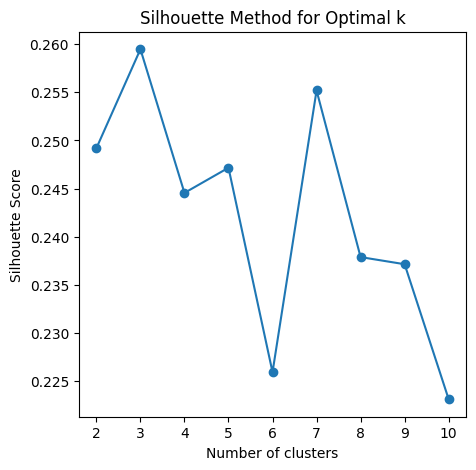

The optimal number of clusters is 3


In [6]:
# 특성 선택 (C to V)
features = data.iloc[:, 1:]
features_standardized = (features - features.mean()) / features.std()

# 최적의 k값 찾기
silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_standardized)
    silhouette_scores.append(silhouette_score(features_standardized, kmeans.labels_))

plt.figure(figsize=(5, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# 최적의 k값
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f'The optimal number of clusters is {optimal_k}')

In [7]:
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(features_standardized)


In [8]:
data['Cluster']

1      0
2      1
3      0
4      1
5      0
      ..
294    1
295    1
296    0
297    1
298    1
Name: Cluster, Length: 298, dtype: int32

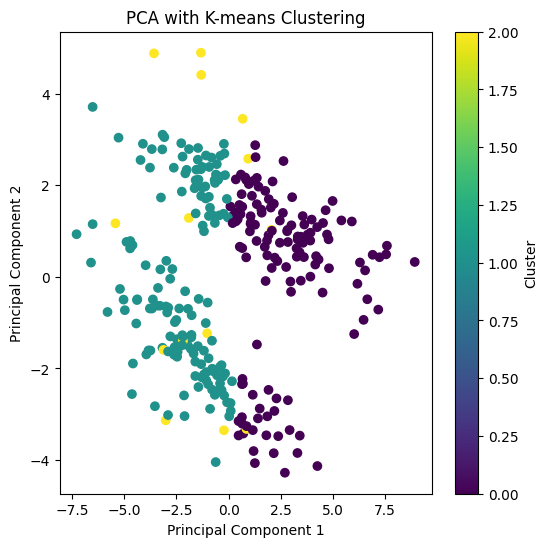

In [9]:
# PCA 수행
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_standardized)
pca_df = pd.DataFrame(data={'PC1': pca_result[:, 0], 'PC2': pca_result[:, 1]})

# PCA 결과 시각화
plt.figure(figsize=(6, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=data['Cluster'], cmap='viridis')
plt.title('PCA with K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')

plt.show()

# 샘플별 예측된 클래스 저장
data['Predicted_Cluster'] = data['Cluster']


In [10]:
# 데이터 분할
X = features_standardized
y = data['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = rf_model.predict(X_test)
classification_rep = classification_report(y_test, y_pred, output_dict=True)
classification_df = pd.DataFrame(classification_rep).transpose()

In [11]:
print(f"Model Prediction Result : {rf_model.score(X_test, y_test)}")
classification_df

Model Prediction Result : 0.9666666666666667


,precision,recall,f1-score,support
0,0.923077,1.000000,0.960000,24.000000
1,1.000000,0.939394,0.968750,33.000000
2,1.000000,1.000000,1.000000,3.000000
accuracy,0.966667,0.966667,0.966667,0.966667
macro avg,0.974359,0.979798,0.976250,60.000000
weighted avg,0.969231,0.966667,0.966812,60.000000


In [12]:
feature_importances = pd.DataFrame(rf_model.feature_importances_, index=features.columns, columns=['Importance'])
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats = 100)
perm_importance_df = pd.DataFrame(perm_importance.importances_mean, index=features.columns, columns=['Permutation Importance'])
perm_importance_df.sort_values(by = 'Permutation Importance', ascending = False, inplace = True)

print(feature_importances)
print(perm_importance_df)

           Importance
Feret        0.125328
Height       0.098808
Major        0.098312
MinFeret     0.089363
Area         0.077239
IntDen       0.076236
BX           0.071975
RawIntDen    0.063011
Minor        0.055276
Round        0.045611
BY           0.044930
AR           0.033265
XM           0.023412
Y            0.021887
X            0.020153
Width        0.018371
YM           0.014870
Angle        0.011212
Perim.       0.005893
Circ.        0.004849
           Permutation Importance
Height                   0.050500
Feret                    0.020667
Round                    0.015500
Area                     0.005833
RawIntDen                0.005333
BX                       0.003833
Major                    0.003500
MinFeret                 0.003500
X                        0.002500
XM                       0.002500
Circ.                    0.000000
AR                      -0.000500
Perim.                  -0.002667
Width                   -0.004500
Y                       -0.0

## **이전 수행 내용의 보완할 점**
- 실루엣 점수가 너무 낮음. 이전 연구에서는 이러한 점이 고려되지 않으며, 군집을 육안으로 확인 했을 시에도 결과가 좋다고 보기엔 어려움
- RandomForest를 활용한 단순 정확도 성능은 높아보이나, 분류된 사진을 육안으로 평가 시 목표하는 형태 기반으로 군집화와 분류가 이루어지지 않음을 확인
- 데이터 분석 미비


## **수행 내용**

- 일관된 표준화 대신 데이터 분포를 고려하여 정규화
- 중복 컬럼, 의미 없는 데이터 삭제, Violinplot을 통해 이상치 확인
- 모델 성능 확인을 통해 수집된 데이터 자체가 목적을 달성하기에는 어려움이 있음을 확인
- 데이터 신뢰성 검증

### **데이터 분석**

**1. Feature Selection**
- 중복 컬럼, 의미 없는 지표 삭제
- (X, Y, XM, YM, BX, BY), (IntDen, RawIntDen) : BoundingBox와 관련된 좌표 값 및 색상과 관련된 변수로 잎의 형태 판별 작업에 영향이 없었기에 제거
- 특히 (X, Y)와 (XM, YM) 값은 Image-J 상에서 의미가 다름에도 값이 일치함, 의미 없는 중복 값은 잘못된 결과를 초래할 수 있음
- (Width, Height) : BoundingBox와 관련된 값으로, 실제 잎의 크기 측정과는 거리가 있으므로 제거
- Angle : 잎의 기울어짐 정도를 나타내는 지표로 잎의 각도로 클러스터링 하는 경우가 발생하여 제거
- Area : 잎을 크기 기준으로 클러스터링 하는 경우가 발생하여 제거


In [13]:
file_path = '../data/soybean_leaflets.csv'
data = pd.read_csv(file_path, index_col = 0)

data[data['X'] != data['XM']] ##일치하는 모습을 보임

,Label,Area,X,Y,XM,YM,Perim.,BX,BY,Width,...,Major,Minor,Angle,Circ.,Feret,IntDen,RawIntDen,MinFeret,AR,Round


In [14]:
data.drop(['X', 'Y', 'XM', 'YM', 'BX', 'BY', 'IntDen','RawIntDen', 'Width', 'Height', 'Area', 'Angle'], axis= 1, inplace=True)
data.head()

,Label,Perim.,Major,Minor,Circ.,Feret,MinFeret,AR,Round
1,DSC00016-1.tif:1330-2089,5077.583,1484.606,1161.616,0.660,2021.983,1557.881,1.278,0.782
2,DSC00016-2.tif:3015-2338,9906.523,1462.916,933.817,0.137,1725.310,1220.654,1.567,0.638
3,DSC00036-1.tif:1537-2190,9367.709,1526.582,1115.868,0.192,2709.291,1867.109,1.368,0.731
4,DSC00036-2.tif:3213-2522,15778.799,1524.490,1171.063,0.071,1677.873,1273.027,1.302,0.768
5,DSC00038-1.tif:1541-2232,11581.778,1732.476,1150.621,0.147,2230.185,1447.708,1.506,0.664


In [15]:
data.describe()

,Perim.,Major,Minor,Circ.,Feret,MinFeret,AR,Round
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,19188.900849,1656.830708,1162.627839,0.124301,1969.786671,1350.250087,1.450007,0.705423
std,15075.730918,232.848253,195.172304,0.124079,347.767315,252.014092,0.262153,0.091632
min,4488.221000,1018.115000,568.369000,0.000557,1099.286000,621.772000,1.124000,0.315000
25%,10478.996500,1502.425250,1028.184750,0.038500,1716.271000,1179.409250,1.316000,0.665250
50%,14707.123500,1652.608500,1149.449500,0.092500,1939.857000,1333.137500,1.396000,0.716000
75%,23050.988500,1802.998500,1300.896500,0.150750,2217.297500,1521.103500,1.503500,0.760000
max,152962.066000,2280.448000,1663.253000,0.660000,3165.067000,2095.874000,3.173000,0.890000


**2. 데이터 전처리**
- 이전 수행 내용에서는 데이터 전처리에 일관된 표준화 방법을 적용하였음
- 각 데이터의 분포에 맞게 표준화 수행
- 데이터의 수가 적은 관계로 이상치는 제거하는 방식보다는 RobustScaler를 통해 최대한 커버

|스케일러	| 장점	| 단점 |	적합한 경우|
|----|---|---|---|
|MinMaxScaler|	간단, 직관적, [0, 1] 범위 조정	|이상치에 민감	|이상치가 없고, 신경망과 같은 모델에 적합|
|StandardScaler|	평균 0, 표준편차 1로 정규화 많은 모델에서 유용|	이상치에 민감 정규분포 데이터가 아니면 부적합|	데이터가 정규분포에 가까울 때|
|RobustScaler|	이상치에 강건 IQR 기반 스케일링 |	[0, 1] 범위로 조정되지 않음|	이상치가 많거나 비정규분포 데이터를 처리할 때|

**데이터가 정규분포에 가까운지 확인**

**시각적 확인**
1. Q-Q Plot (Quantile-Quantile Plot)
    - 데이터의 분포를 이론적인 정규분포와 비교하여 확인. Q-Q 플롯에서 점들이 대각선에 가까울수록 데이터가 정규분포에 가까움

2. 히스토그램
    - 데이터를 히스토그램으로 시각화하여 분포가 종 모양(bell-shaped curve)을 가지는지 확인

**정량적 확인**

(1) 기술통계량

* 데이터의 왜도와 첨도
    * 왜도: 0에 가까우면 정규분포
        - skewness가 -0.5 ~ 0,5 일 경우 데이터는 상당히 대칭적이다.
        - skewness가 -1\~-0.5이거나 0.5\~1 일 경우 데이터는 적당히 치우쳐있다
        - skewness가 -1보다 작거나 1보다 클 경우 데이터는 상당히 치우쳐있다
    * 첨도: 정규분포는 3에 가까우나 excess Kurtosis는 0에 가까움
   
(2) 정규성검정

* 귀무가설: 데이터가 정규분포를 따른다.
* p-value가 0.05 이상이면 정규성을 만족한다고 판단.

    * Shapiro-Wilk Test : 데이터 샘플을 정규분포로 변환했을 때, 변환된 데이터가 정규성을 얼마나 잘 만족하는지 측정, 샘플 크기가 작을 때에도 높은 신뢰도로 정규성을 평가가능 -> **소규모 데이터에 효과적**
    * Kolmogorov-Smirnov Test: 데이터의 분포가 특정 이론적 분포와 일치하는지 확인, *정규성 검정에서 평균과 분산이 정규분포와 동일해야한다는 설정이 필요* -> **현재 데이터의 분포를 확인하려는 목적과 맞지 않음**
  


In [16]:
features = data.iloc[:, 1:]

Perim. : shapiro p value (> 0.05) = 0.000, skew_p (== 0) = 3.593, kurtosis (== 0) = 22.273
Major : shapiro p value (> 0.05) = 0.248, skew_p (== 0) = 0.173, kurtosis (== 0) = 0.058
Minor : shapiro p value (> 0.05) = 0.726, skew_p (== 0) = -0.034, kurtosis (== 0) = -0.020
Circ. : shapiro p value (> 0.05) = 0.000, skew_p (== 0) = 1.830, kurtosis (== 0) = 3.290
Feret : shapiro p value (> 0.05) = 0.069, skew_p (== 0) = 0.244, kurtosis (== 0) = -0.229
MinFeret : shapiro p value (> 0.05) = 0.769, skew_p (== 0) = 0.086, kurtosis (== 0) = 0.117
AR : shapiro p value (> 0.05) = 0.000, skew_p (== 0) = 3.171, kurtosis (== 0) = 12.833
Round : shapiro p value (> 0.05) = 0.000, skew_p (== 0) = -1.364, kurtosis (== 0) = 3.323


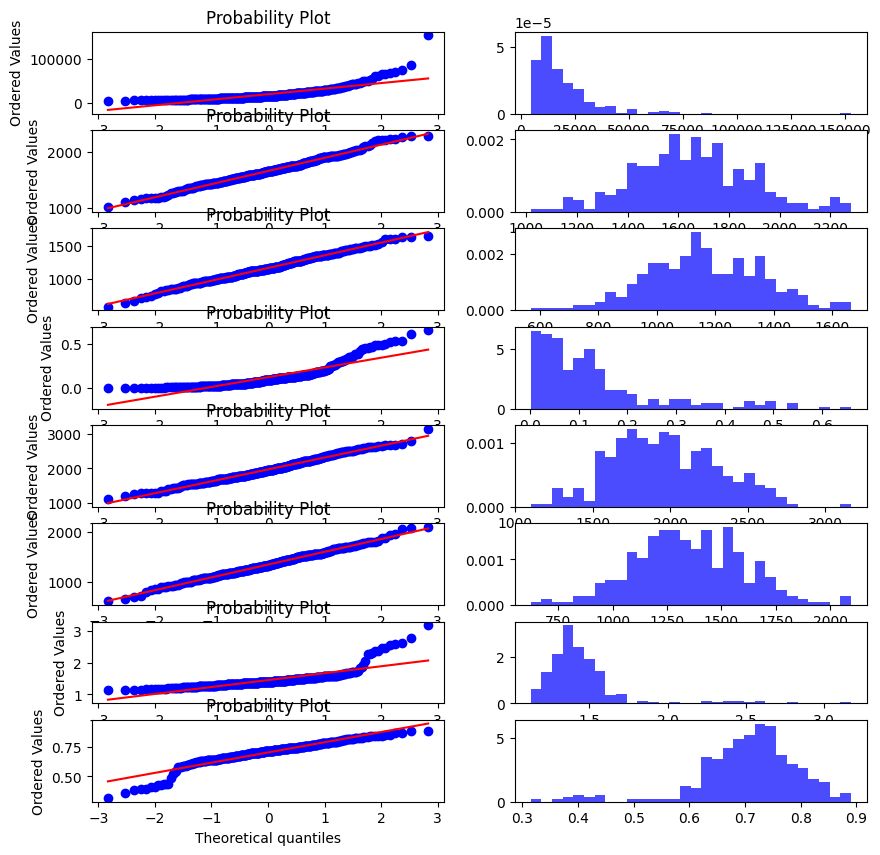

In [17]:
fig, ax = plt.subplots(len(features.columns),2,figsize=(10,10))

for i in range(len(features.columns)):
    stats.probplot(features[features.columns[i]], dist="norm", plot=ax[i,0])
    ax[i,1].hist(features[features.columns[i]], bins=30, alpha=0.7, color='blue', density=True)
    _, shap_p = shapiro(features[features.columns[i]])
    skew_p, kur_p = skew(features[features.columns[i]]), kurtosis(features[features.columns[i]])
    
    print(f"{features.columns[i]} : shapiro p value (> 0.05) = {shap_p:.3f}, skew_p (== 0) = {skew_p:.3f}, kurtosis (== 0) = {kur_p:.3f}")

**3. 이상치에 따른 정규화 적용**
- 이상치의 정도에 따라 Robust, Standard 설정
- 이상치가 많으면 Robust, 정규 분포를 따르면 Standard로 설정
- 그러나 여전히 군집화의 결과가 뚜렷하지 않음

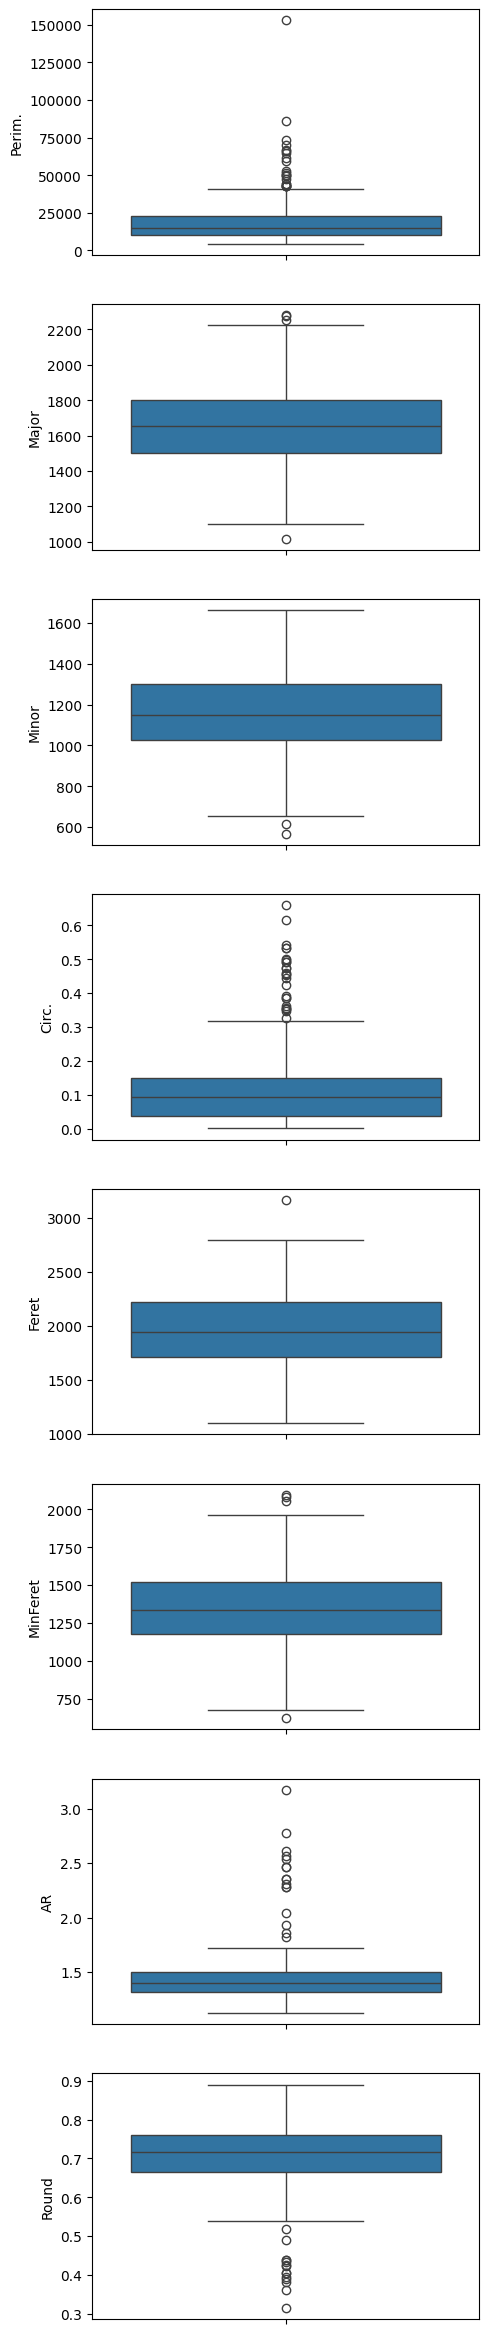

In [18]:
fig, ax = plt.subplots(len(features.columns),1,figsize=(5,30))

for i in range(len(features.columns)):
    sns.boxplot(data = features[features.columns[i]], ax = ax[i])

In [19]:
Perim_Scaler = RobustScaler()
Major_Scaler = StandardScaler()
Minor_Scaler = StandardScaler()  #MinMaxScaler()
Cir_Scaler = RobustScaler()
Feret_Scaler = StandardScaler() #MinMaxScaler()
Minferet_Scaler = StandardScaler() #MinMaxScaler()
AR_Scaler = RobustScaler()
Round_Scaler = RobustScaler()

In [20]:
features['AR'] = AR_Scaler.fit_transform(data[['AR']])
features['MinFeret'] = Minferet_Scaler.fit_transform(data[['MinFeret']])
features['Feret'] = Feret_Scaler.fit_transform(data[['Feret']])
features['Circ.'] = Cir_Scaler.fit_transform(data[['Circ.']])
features['Minor'] = Minor_Scaler.fit_transform(data[['Minor']])
features['Major'] = Major_Scaler.fit_transform(data[['Major']])
features['Round'] = Round_Scaler.fit_transform(data[['Round']])
features['Perim.'] = Perim_Scaler.fit_transform(data[['Perim.']])

features_standardized = features


In [21]:
features_standardized.describe()

,Perim.,Major,Minor,Circ.,Feret,MinFeret,AR,Round
count,2.980000e+02,2.980000e+02,2.980000e+02,298.000000,2.980000e+02,2.980000e+02,298.000000,298.000000
mean,3.564890e-01,-8.345301e-17,3.576557e-17,0.283301,-9.537486e-16,-1.430623e-16,0.288036,-0.111633
std,1.199152e+00,1.001682e+00,1.001682e+00,1.105379,1.001682e+00,1.001682e+00,1.398149,0.967092
min,-8.128308e-01,-2.747670e+00,-3.049912e+00,-0.819091,-2.507323e+00,-2.895487e+00,-1.450667,-4.232190
25%,-3.363132e-01,-6.642317e-01,-6.900018e-01,-0.481069,-7.302069e-01,-6.790422e-01,-0.426667,-0.535620
50%,-7.242471e-17,-1.816338e-02,-6.763514e-02,0.000000,-8.620711e-02,-6.801751e-02,0.000000,0.000000
75%,6.636868e-01,6.287943e-01,7.096357e-01,0.518931,7.129111e-01,6.790922e-01,0.573333,0.464380
max,1.099706e+01,2.682718e+00,2.569357e+00,5.055679,3.442793e+00,2.963636e+00,9.477333,1.836412


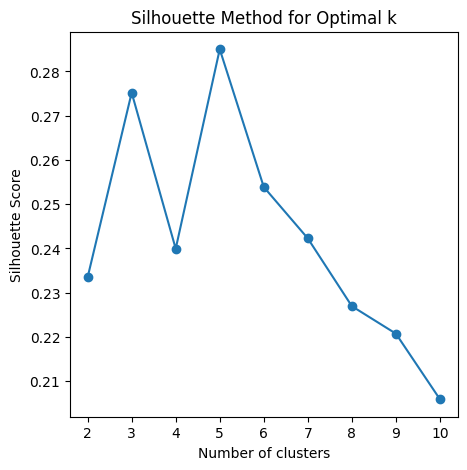

The optimal number of clusters is 5


In [22]:
# 최적의 k값 찾기
silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_standardized)
    silhouette_scores.append(silhouette_score(features_standardized, kmeans.labels_))

plt.figure(figsize=(5, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# 최적의 k값
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f'The optimal number of clusters is {optimal_k}')

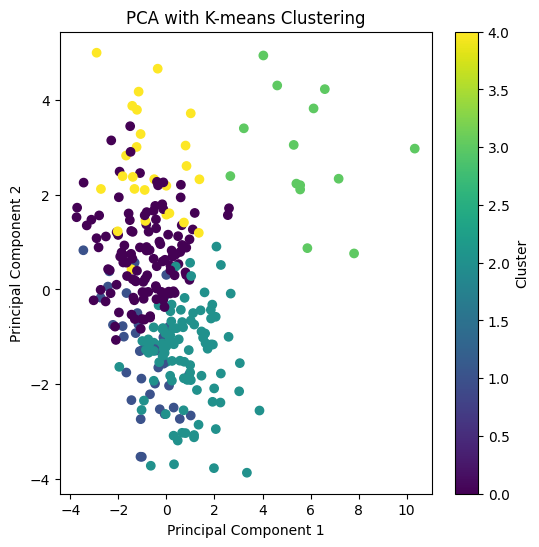

In [23]:
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(features_standardized)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_standardized)
pca_df = pd.DataFrame(data={'PC1': pca_result[:, 0], 'PC2': pca_result[:, 1]})

# PCA 결과 시각화
plt.figure(figsize=(6, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=data['Cluster'], cmap='viridis')
plt.title('PCA with K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')

plt.show()

In [24]:
data['Cluster'].value_counts()

Cluster
0    117
2    101
1     40
4     26
3     14
Name: count, dtype: int64

**4. 군집별 데이터 확인**
* Perim.의 경우 표준화를 수행하였음에도 과도하게 높은 값이 존재함을 확인

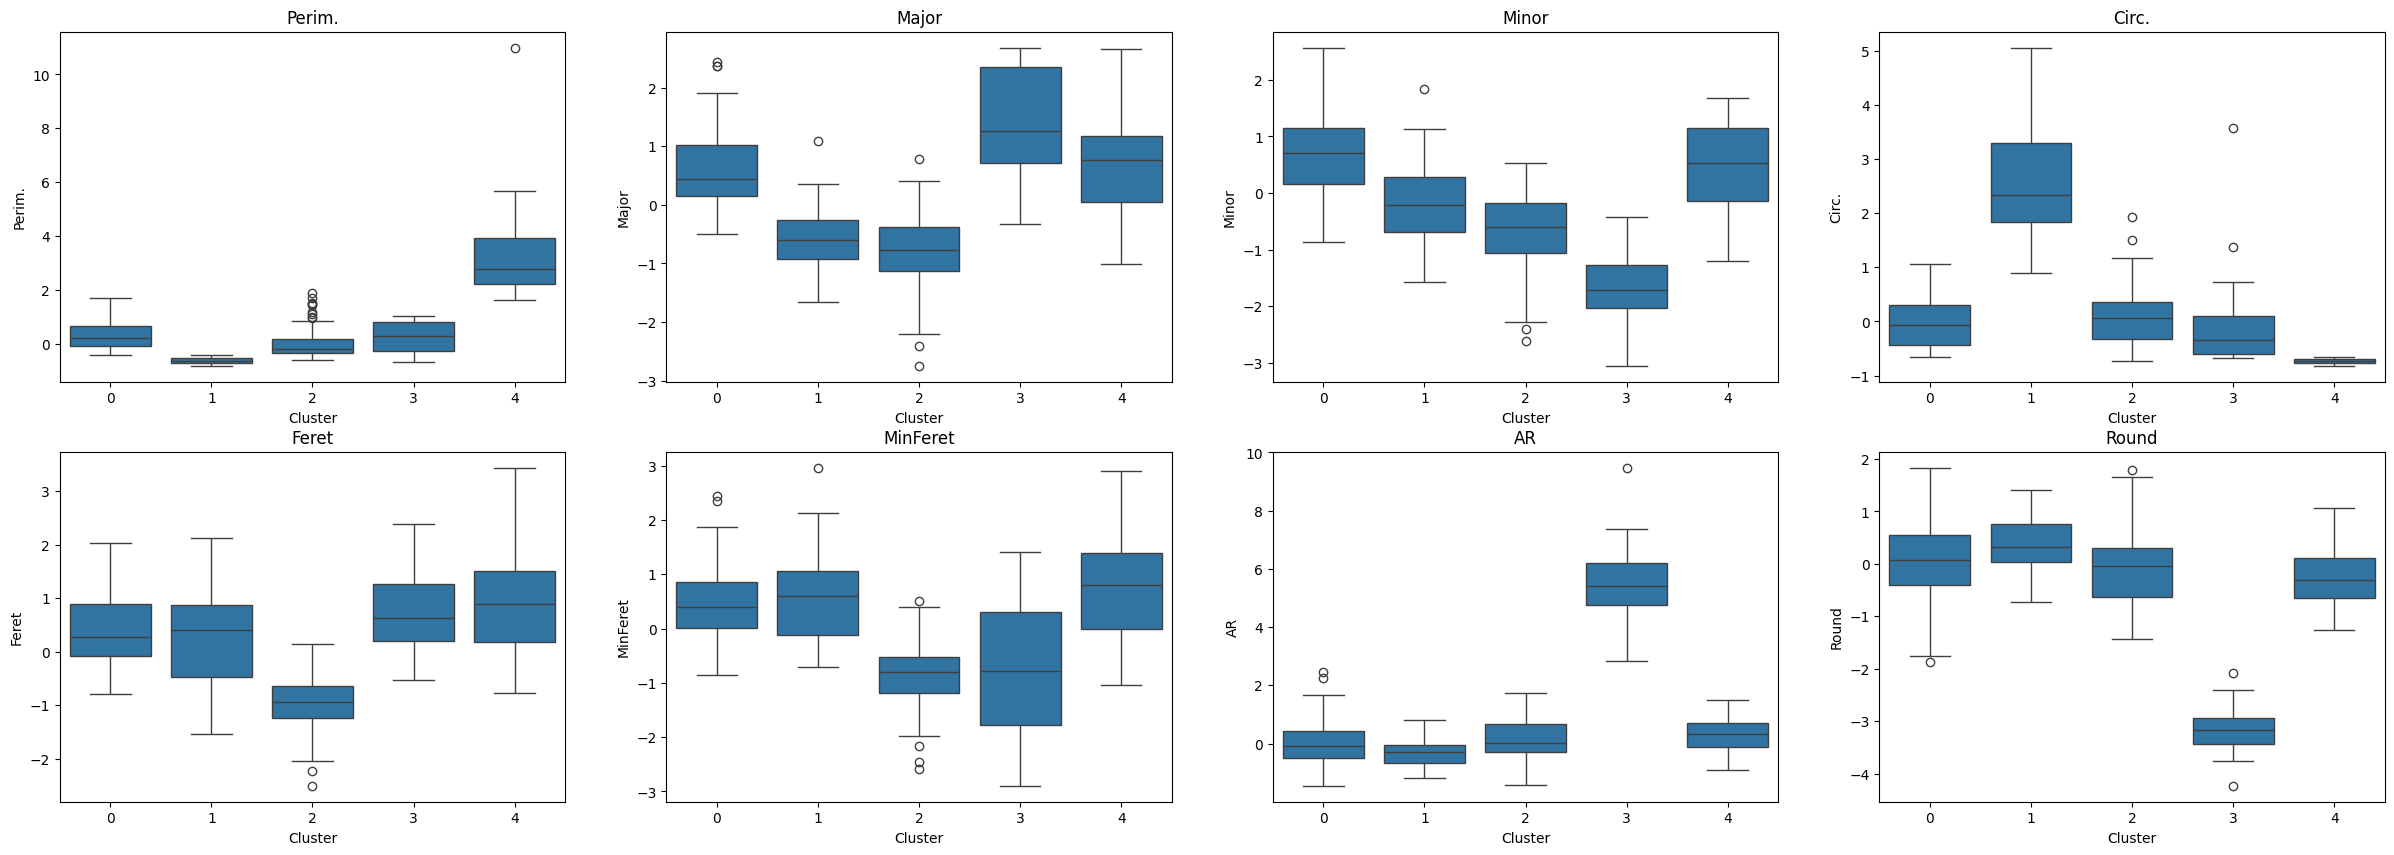

In [25]:
fig, ax = plt.subplots(2,4,figsize=(30,10))
for i in range(0, len(data.columns)-2):
    row, col = divmod(i, 4)
    sns.boxplot(x = data['Cluster'], y= features[data.columns[i+1]], ax= ax[row, col])
    ax[row, col].set_title(data.columns[i+1])

**5. 데이터 육안 확인**
* 150,000의 Perim. 값을 갖는 데이터 확인
* DSC00291-1 의 Perim.는 **65,987**, DSC00768-1의 Perim은 **152,962**임 육안으로 확인 시 DSC00291-1가 더 커보임
* Image-J에서 Perim. 측정 과정에서 어떠한 문제가 있는 것으로 보임
* **Perim 변수의 신뢰성이 떨어지며, Circ. 변수 또한 Perim의 값에서 파생 변수임으로 신뢰성이 떨어짐**

In [26]:
data[data['Label'] == 'DSC00292-1.tif:1233-2073']

,Label,Perim.,Major,Minor,Circ.,Feret,MinFeret,AR,Round,Cluster
94,DSC00292-1.tif:1233-2073,65987.986,1963.026,1348.193,0.006,2467.423,1708.137,1.456,0.687,4


In [27]:
data[data['Label'] == 'DSC00768-1.tif:1195-2235']

,Label,Perim.,Major,Minor,Circ.,Feret,MinFeret,AR,Round,Cluster
164,DSC00768-1.tif:1195-2235,152962.066,1421.184,929.659,0.000557,1919.407,1171.0,1.529,0.654,4


**DSC00292-1, Perim.= 65,987**
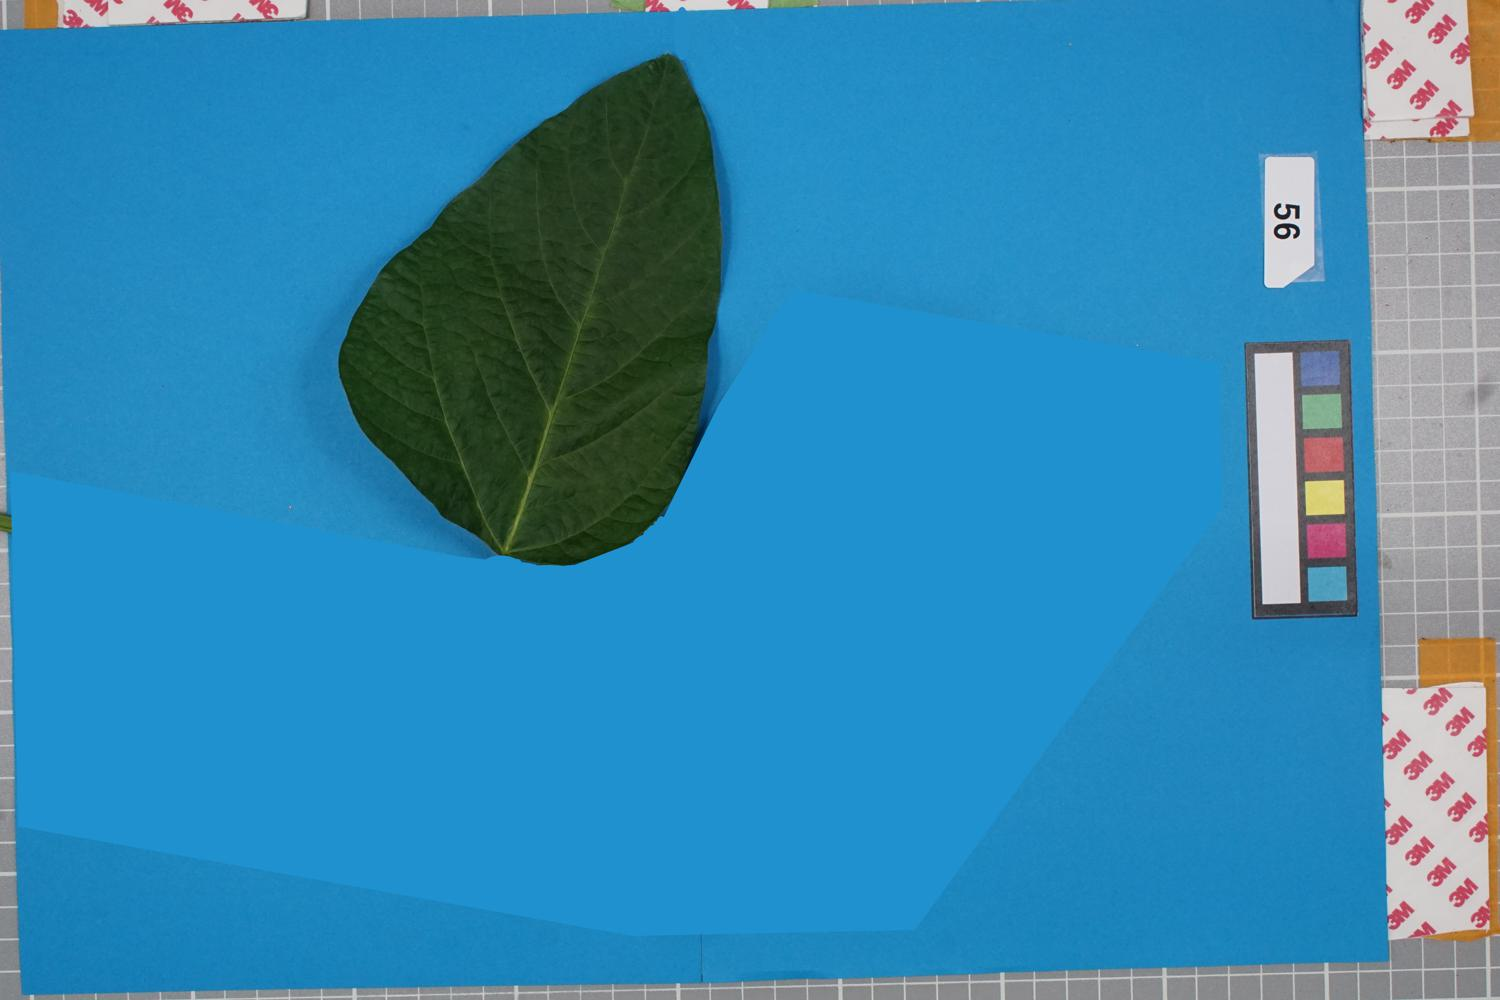

**DSC00768-1, Perim.= 152,962**

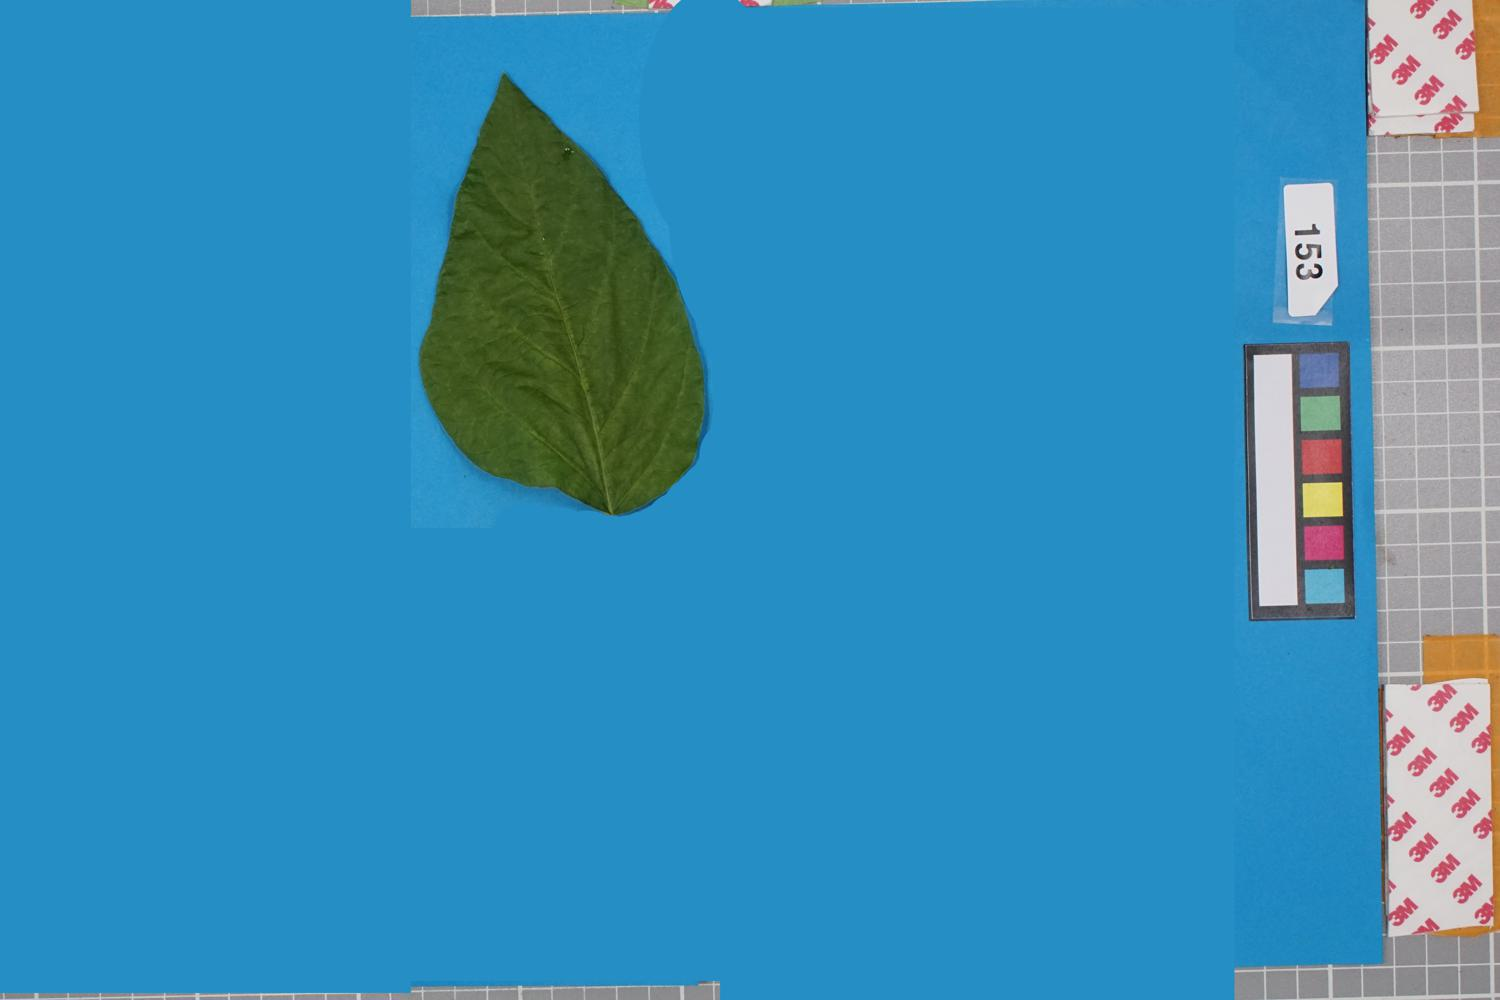

**5. 데이터 전처리 수정**
* Perim., Circ. 제거
* 다른 scaler들을 적용하여 비교, 큰 차이가 없음을 확인

In [28]:
file_path = '../data/soybean_leaflets.csv'
data = pd.read_csv(file_path, index_col = 0)
data.drop(['X', 'Y', 'XM', 'YM', 'BX', 'BY', 'IntDen','RawIntDen', 'Width', 'Height', 'Area', 'Angle', 'Perim.', 'Circ.'], axis= 1, inplace=True)
features = data.iloc[:, 1:]

Major_Scaler = MinMaxScaler() # StandardScaler
Minor_Scaler = MinMaxScaler()  #MinMaxScaler()
Feret_Scaler = MinMaxScaler() #MinMaxScaler()
Minferet_Scaler = MinMaxScaler() #MinMaxScaler()
AR_Scaler = RobustScaler() ## RobustScaler()
Round_Scaler = RobustScaler()

In [29]:

features['MinFeret'] = Minferet_Scaler.fit_transform(data[['MinFeret']])
features['Feret'] = Feret_Scaler.fit_transform(data[['Feret']])
features['Minor'] = Minor_Scaler.fit_transform(data[['Minor']])
features['Major'] = Major_Scaler.fit_transform(data[['Major']])
features['Round'] = Round_Scaler.fit_transform(data[['Round']])
features['AR'] = AR_Scaler.fit_transform(data[['AR']])

features_standardized = features
features_standardized.describe()

,Major,Minor,Feret,MinFeret,AR,Round
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,0.505980,0.542760,0.421391,0.494184,0.288036,-0.111633
std,0.184459,0.178258,0.168347,0.170961,1.398149,0.967092
min,0.000000,0.000000,0.000000,0.000000,-1.450667,-4.232190
25%,0.383663,0.419968,0.298669,0.378289,-0.426667,-0.535620
50%,0.502636,0.530723,0.406902,0.482575,0.000000,0.000000
75%,0.621772,0.669046,0.541205,0.610088,0.573333,0.464380
max,1.000000,1.000000,1.000000,1.000000,9.477333,1.836412


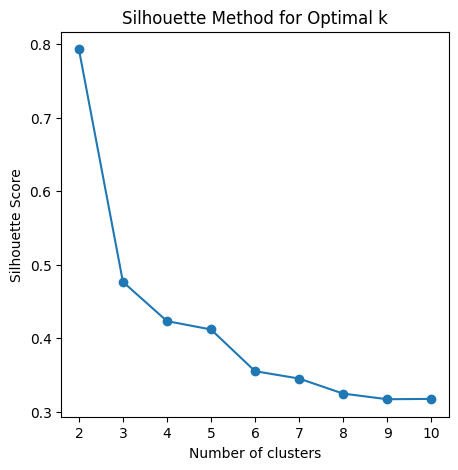

The optimal number of clusters is 2


In [30]:
# 최적의 k값 찾기
silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_standardized)
    silhouette_scores.append(silhouette_score(features_standardized, kmeans.labels_))

plt.figure(figsize=(5, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# 최적의 k값
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f'The optimal number of clusters is {optimal_k}')

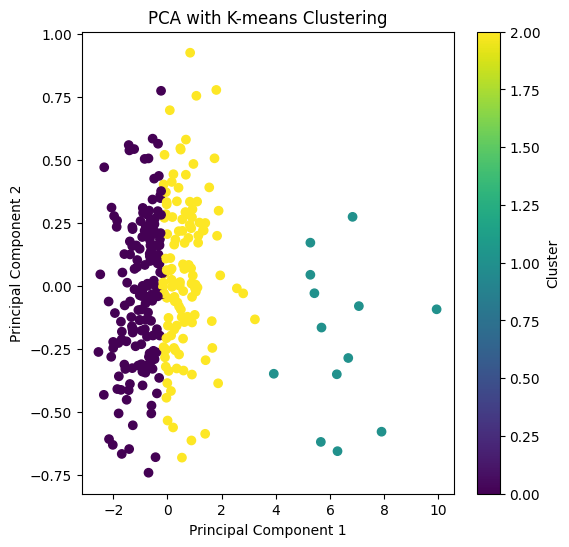

In [31]:
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(features_standardized)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_standardized)
pca_df = pd.DataFrame(data={'PC1': pca_result[:, 0], 'PC2': pca_result[:, 1]})

# PCA 결과 시각화
plt.figure(figsize=(6, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=data['Cluster'], cmap='viridis')
plt.title('PCA with K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')

plt.show()

In [32]:
score_samples = silhouette_samples(features_standardized, kmeans.labels_)
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

tmp = data.copy()
tmp['silhouette_coeff'] = score_samples
tmp['cluster'] = kmeans.labels_

tmp.groupby('cluster')['silhouette_coeff'].mean()


silhouette_samples( ) return 값의 shape (298,)


cluster
0    0.481043
1    0.676065
2    0.449518
Name: silhouette_coeff, dtype: float64

In [33]:
centroids = kmeans.cluster_centers_

# 각 특성별 분산 계산 (클러스터 중심의 분산이 높을수록 중요도가 높음)
feature_variance = np.var(centroids, axis=0)

# 특성 중요도 정렬
feature_importance = pd.Series(feature_variance, index=features_standardized.columns).sort_values(ascending=False)
feature_importance

AR          7.340843
Round       2.500933
Minor       0.025275
Major       0.018176
MinFeret    0.006822
Feret       0.004436
dtype: float64

In [34]:
data['Cluster'].value_counts()

Cluster
0    162
2    123
1     13
Name: count, dtype: int64

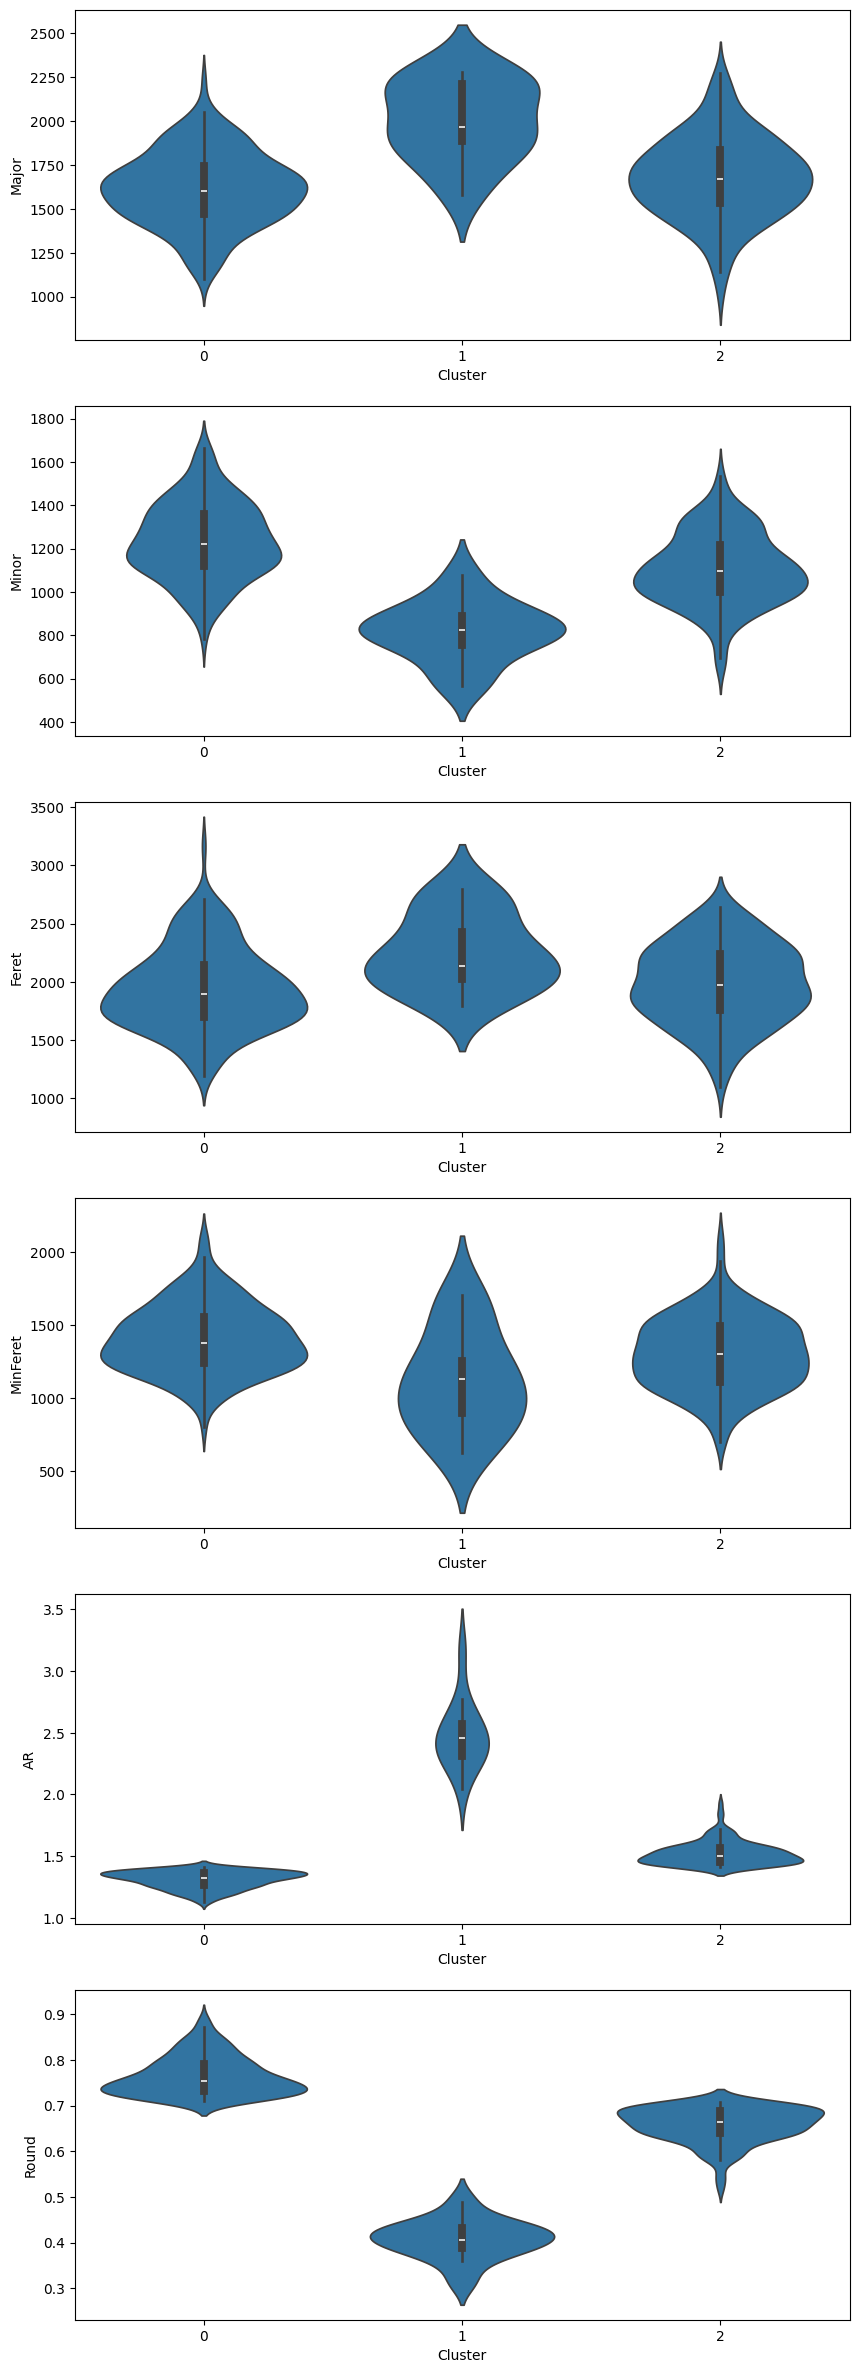

In [35]:
fig, ax = plt.subplots(6,1,figsize=(10,30))
for i in range(0,6):
    sns.violinplot(x = data['Cluster'], y= data[data.columns[i+1]], ax= ax[i])

**데이터 육안 평가**
- 육안 확인 시 연구 목표에 부합한 군집화가 형성되지 않음을 확인
- 현 수치 데이터 상에서는 목적하는 특징 값이 존재하지 않는 것으로 보이며, 본 작업을 위한 데이터 특징 수집이 필요함

In [36]:
# for index, row in tqdm(data.iterrows()):    
#     origin_img = os.path.join('../data/blue_background_298', row['Label'].split(':')[0])
#     try:
#         with Image.open(origin_img) as img:
#             rgb_img = img.convert("RGB")
#             rgb_img = rgb_img.resize((1500, 1000))
#             output_path = os.path.join('../result/Non_XY/kcluster_3_re_re/correct', f"cluster_{row['Cluster']}", row['Label'].split(':')[0].split('.')[0]+".jpg")
#             os.makedirs(os.path.dirname(output_path), exist_ok = True)
#             rgb_img.save(output_path, format = 'JPEG')
#     except:
#         print(f" {row['Label']} is error file")


# # 데이터 분할
# X = features_standardized
# y = data['Cluster']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Random Forest 모델 학습
# rf_model = RandomForestClassifier(random_state=42)
# rf_model.fit(X_train, y_train)

# # 예측 및 평가
# y_pred = rf_model.predict(X_test)
# classification_rep = classification_report(y_test, y_pred, output_dict=True)
# classification_df = pd.DataFrame(classification_rep).transpose()